In [1]:
import warnings

warnings.filterwarnings('ignore')
import numpy as _np
#from bgen_reader import open_bgen
#from os.path import join
#from pandas_plink import read_plink1_bin
#from pandas_plink import get_data_folder
# import matplotlib.pyplot as plt
#from bgen_reader import open_bgen
#from bed_reader import open_bed, sample_file
# import pandas as pd
# import os
# from pysnptools.distreader import Bgen, DistMemMap
# from pathlib import Path
from numba import jit as _jit
from bed_reader import open_bed as _open_bed
# from pysnptools.snpreader import SnpData, SnpMemMap
# from pysnptools.util import log_in_place
# import matplotlib.pyplot as plt
# from scipy.stats import gaussian_kde
from KDEpy import FFTKDE as _FFTKDE
import pandas as _pd
from sklearn.preprocessing import RobustScaler as _scaler
# from pybgen import PyBGEN
import multiprocess as _mp

In [2]:
@_jit(nogil=True, cache=True, parallel=True)
def MI_continuous_SNP(a,
                      b,
                      N=500,
                      kernel="epa",
                      bw="silverman",
                      machine_err=1e-16):
    """
    calculate mutual information between continuous outcome and an SNP variable of 0,1,2
    assume no missing data
    """
    # first estimate the pmf
    p0 = _np.sum(b == 0) / len(b)
    p1 = _np.sum(b == 1) / len(b)
    p2 = 1. - p0 - p1
    _a = _scaler().fit_transform(a.reshape(-1, 1)).flatten()
    # this step is just to get the boundary width for the joint density grid
    # the three conditional density estimates need to be evaluated on the joint density grid
    a_temp, _ = _FFTKDE(kernel=kernel, bw=bw).fit(data=_a).evaluate(N)
    # estimate cond density
    _b0 = (b == 0)
    if _np.sum(_b0) > 2:
        # here proceed to kde only if there are more than 5 data points
        y_cond_p0 = _FFTKDE(kernel=kernel, bw=bw).fit(data=_a[_b0])
#         y_cond_p0 = gaussian_kde(_a[_b0])
    else:
        y_cond_p0 = _np.zeros_like
    _b1 = (b == 1)
    if _np.sum(_b1) > 2:
        y_cond_p1 = _FFTKDE(kernel=kernel, bw=bw).fit(data=_a[_b1])
#         y_cond_p1 = gaussian_kde(_a[_b1]) # this thing uses Scott's rule instead of Silverman defaulted by FFTKDE and R density
    else:
        y_cond_p1 = _np.zeros_like
    _b2 = (b == 2)
    if _np.sum(_b2) > 2:
        y_cond_p2 = _FFTKDE(kernel=kernel, bw=bw).fit(data=_a[_b2])


#         y_cond_p2 = gaussian_kde(_a[_b2])
    else:
        y_cond_p2 = _np.zeros_like
    joint = _np.empty((N, 3))
    joint[:, 0] = y_cond_p0(a_temp) * p0
    joint[:, 1] = y_cond_p1(a_temp) * p1
    joint[:, 2] = y_cond_p2(a_temp) * p2
    mask = joint < machine_err
    forward_euler_step = a_temp[1] - a_temp[0]
    joint[mask] = 0.
    # to scale the cdf to 1.
    joint /= _np.sum(joint) * forward_euler_step
    #     print("total measure:",  _np.sum(joint)*forward_euler_step)
    temp_log = _np.log(joint)
    temp_log = _np.nan_to_num(temp_log, nan=0)
    temp1 = _np.log(_np.sum(joint, 1))
    temp1 = _np.nan_to_num(temp1, nan=0)
    temp_log = temp_log - temp1.reshape(-1, 1)
    temp2 = _np.log(_np.sum(joint, 0)) + _np.log(forward_euler_step)
    temp2 = _np.nan_to_num(temp2, nan=0)
    temp_log = temp_log - temp2.reshape(1, -1)
    # print(fhat_mat * temp_log)
    temp_mat = joint * temp_log
    #     temp_mat =  _np.nan_to_num(temp_mat, nan=0.) # numerical fix
    mi_temp = _np.sum(temp_mat) * forward_euler_step

    # this is to ensure that estimated MI is positive, to solve an numerical issue
    if mi_temp < machine_err:
        mi_temp = machine_err

    return mi_temp


@_jit(nogil=True, cache=True, parallel=True)
def MI_binary_SNP(a, b, machine_err=1e-16):
    """
    calculate mutual information between binary outcome and an SNP variable of 0,1,2
    assume no missing data
    """
    # first estimate the pmf of SNP
    p0 = _np.sum(b == 0) / len(b)
    p1 = _np.sum(b == 1) / len(b)
    p2 = 1. - p0 - p1
    b_marginal = _np.array([p0, p1, p2])
    # estimate pmf of the binary outcome
    a_p0 = _np.sum(a == 0) / len(a)
    a_p1 = _np.sum(a == 1) / len(a)
    a_marginal = _np.array([a_p0, a_p1]).reshape(-1, 1)
    # estimate the cond density
    joint = _np.zeros((2, 3))
    _b0 = (b == 0)
    joint[0, 0] = _np.sum(a[_b0] == 0) / len(a)
    joint[1, 0] = _np.sum(a[_b0] == 1) / len(a)
    _b1 = (b == 1)
    joint[0, 1] = _np.sum(a[_b1] == 0) / len(a)
    joint[1, 1] = _np.sum(a[_b1] == 1) / len(a)
    _b2 = (b == 2)
    joint[0, 2] = _np.sum(a[_b2] == 0) / len(a)
    joint[1, 2] = _np.sum(a[_b2] == 1) / len(a)

    _ = a_marginal * b_marginal
    _ = joint / _
    __ = joint * _np.log(_)
    __ = _np.nan_to_num(__, nan=0.0)  # for possible nuemrical issues

    mi_temp = _np.sum(__)

    # this is to ensure that estimated MI is positive, to solve an numerical issue
    if mi_temp < machine_err:
        mi_temp = machine_err

    return mi_temp


# make this function available
@_jit(nogil=True, cache=True, parallel=True)
def MI_bivariate_continuous(a,
                            b,
                            a_N=300,
                            b_N=300,
                            kernel="epa",
                            bw="silverman",
                            norm=2,
                            machine_err=1e-16):
    """
    (Single Core version) calculate mutual information on bivariate continuous r.v..
    """
    _ = _np.argsort(a)
    data = _np.hstack((a[_].reshape(-1, 1), b[_].reshape(-1, 1)))
    _data = _scaler().fit_transform(data)
    grid, joint = _FFTKDE(kernel=kernel, norm=norm).fit(_data).evaluate(
        (a_N, b_N))
    joint = joint.reshape(b_N, -1).T
    # this gives joint as a (a_N, b_N) array, following example: https://kdepy.readthedocs.io/en/latest/examples.html#the-effect-of-norms-in-2d
    a_forward_euler_step = grid[b_N, 0] - grid[0, 0]
    b_forward_euler_step = grid[1, 1] - grid[0, 1]
    mask = joint < machine_err
    joint[mask] = 0.
    # to scale the cdf to 1.
    joint /= _np.sum(joint) * a_forward_euler_step * b_forward_euler_step
    log_a_marginal = _np.log(_np.sum(joint, 1)) + _np.log(b_forward_euler_step)
    log_a_marginal = _np.nan_to_num(log_a_marginal, nan=0)
    log_b_marginal = _np.log(_np.sum(joint, 0)) + _np.log(a_forward_euler_step)
    log_b_marginal = _np.nan_to_num(log_b_marginal, nan=0)
    log_joint = _np.log(joint)
    log_joint = _np.nan_to_num(log_joint, nan=0)
    mi_temp = _np.sum(
        joint *
        (log_joint - log_a_marginal.reshape(-1, 1) - log_b_marginal.reshape(
            1, -1))) * a_forward_euler_step * b_forward_euler_step

    # this is to ensure that estimated MI is positive, to solve an numerical issue
    if mi_temp < machine_err:
        mi_temp = machine_err

    return mi_temp


# make this function available
@_jit(nogil=True, cache=True, parallel=True)
def MI_binary_continuous(a,
                         b,
                         N=500,
                         kernel="epa",
                         bw="silverman",
                         machine_err=1e-16):
    return MI_continuous_SNP(a=b,
                             b=a,
                             N=N,
                             kernel=kernel,
                             bw=bw,
                             machine_err=machine_err)


# outcome_iid should be a  list of strings for identifiers
def continuous_filter_plink(bed_file,
                            bim_file,
                            fam_file,
                            outcome,
                            outcome_iid,
                            N=500,
                            kernel="epa",
                            bw="silverman",
                            machine_err=1e-16):
    """
    (Single Core version) take plink files to calculate the mutual information between the continuous outcome and many SNP variables.
    """
    bed1 = _open_bed(filepath=bed_file,
                     fam_filepath=fam_file,
                     bim_filepath=bim_file)
    gene_iid = _np.array(list(bed1.iid))
    bed1_sid = _np.array(list(bed1.sid))
    outcome = outcome[_np.intersect1d(outcome_iid,
                                      gene_iid,
                                      assume_unique=True,
                                      return_indices=True)[1]]

    # get genetic indices
    gene_ind = _np.intersect1d(gene_iid,
                               outcome_iid,
                               assume_unique=True,
                               return_indices=True)[1]
    MI_UKBB = _np.zeros(len(bed1_sid))
    for j in range(len(MI_UKBB)):
        _SNP = bed1.read(_np.s_[:, j], dtype=_np.int8).flatten()
        _SNP = _SNP[gene_ind]  # get gene iid also in outcome iid
        _outcome = outcome[_SNP != -127]  # remove missing SNP in outcome
        _SNP = _SNP[_SNP != -127]  # remove missing SNP
        MI_UKBB[j] = MI_continuous_SNP(a=_outcome,
                                       b=_SNP,
                                       N=N,
                                       kernel=kernel,
                                       bw=bw,
                                       machine_err=machine_err)
    return MI_UKBB


def binary_filter_plink(bed_file,
                        bim_file,
                        fam_file,
                        outcome,
                        outcome_iid,
                        machine_err=1e-16):
    """
    (Single Core version) take plink files to calculate the mutual information between the binary outcome and many SNP variables.
    """
    bed1 = _open_bed(filepath=bed_file,
                     fam_filepath=fam_file,
                     bim_filepath=bim_file)
    gene_iid = _np.array(list(bed1.iid))
    bed1_sid = _np.array(list(bed1.sid))
    outcome = outcome[_np.intersect1d(outcome_iid,
                                      gene_iid,
                                      assume_unique=True,
                                      return_indices=True)[1]]
    # get genetic indices
    gene_ind = _np.intersect1d(gene_iid,
                               outcome_iid,
                               assume_unique=True,
                               return_indices=True)[1]
    MI_UKBB = _np.zeros(len(bed1_sid))
    for j in range(len(MI_UKBB)):
        _SNP = bed1.read(_np.s_[:, j], dtype=_np.int8).flatten()
        _SNP = _SNP[gene_ind]  # get gene iid also in outcome iid
        _outcome = outcome[_SNP != -127]  # remove missing SNP in outcome
        _SNP = _SNP[_SNP != -127]  # remove missing SNP
        MI_UKBB[j] = MI_binary_SNP(a=_outcome, b=_SNP, machine_err=machine_err)
    return MI_UKBB


def continuous_filter_plink_parallel(bed_file,
                                     bim_file,
                                     fam_file,
                                     outcome,
                                     outcome_iid,
                                     N=500,
                                     kernel="epa",
                                     bw="silverman",
                                     machine_err=1e-16,
                                     core_num="NOT DECLARED",
                                     multp=1):
    """
    (Multiprocessing version) take plink files to calculate the mutual information between the continuous outcome and many SNP variables.
    """
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert core_num <= _mp.cpu_count(
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    bed1 = _open_bed(filepath=bed_file,
                     fam_filepath=fam_file,
                     bim_filepath=bim_file)
    gene_iid = _np.array(list(bed1.iid))
    bed1_sid = _np.array(list(bed1.sid))
    outcome = outcome[_np.intersect1d(outcome_iid,
                                      gene_iid,
                                      assume_unique=True,
                                      return_indices=True)[1]]
    # get genetic indices
    gene_ind = _np.intersect1d(gene_iid,
                               outcome_iid,
                               assume_unique=True,
                               return_indices=True)[1]

    def _continuous_filter_plink_slice(_slice):
        _MI_slice = _np.zeros(len(_slice))
        k = 0
        for j in _slice:
            _SNP = bed1.read(_np.s_[:, j], dtype=_np.int8).flatten()
            _SNP = _SNP[gene_ind]  # get gene iid also in outcome iid
            _outcome = outcome[_SNP != -127]  # remove missing SNP in outcome
            _SNP = _SNP[_SNP != -127]  # remove missing SNP
            _MI_slice[k] = MI_continuous_SNP(a=_outcome,
                                             b=_SNP,
                                             N=N,
                                             kernel=kernel,
                                             bw=bw,
                                             machine_err=machine_err)
            k += 1
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(len(bed1_sid))
    with _mp.Pool(core_num) as pl:
        MI_UKBB = pl.map(_continuous_filter_plink_slice,
                         _np.array_split(ind, core_num * multp))
    MI_UKBB = _np.hstack(MI_UKBB)
    return MI_UKBB


def binary_filter_plink_parallel(bed_file,
                                 bim_file,
                                 fam_file,
                                 outcome,
                                 outcome_iid,
                                 core_num="NOT DECLARED",
                                 multp=1,
                                 machine_err=1e-16):
    """
    (Multiprocessing version) take plink files to calculate the mutual information between the binary outcome and many SNP variables.
    """
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert core_num <= _mp.cpu_count(
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    bed1 = _open_bed(filepath=bed_file,
                     fam_filepath=fam_file,
                     bim_filepath=bim_file)
    gene_iid = _np.array(list(bed1.iid))
    bed1_sid = _np.array(list(bed1.sid))
    outcome = outcome[_np.intersect1d(outcome_iid,
                                      gene_iid,
                                      assume_unique=True,
                                      return_indices=True)[1]]
    # get genetic indices
    gene_ind = _np.intersect1d(gene_iid,
                               outcome_iid,
                               assume_unique=True,
                               return_indices=True)[1]

    def _binary_filter_plink_slice(_slice):
        _MI_slice = _np.zeros(len(_slice))
        k = 0
        for j in _slice:
            _SNP = bed1.read(_np.s_[:, j], dtype=_np.int8).flatten()
            _SNP = _SNP[gene_ind]  # get gene iid also in outcome iid
            _outcome = outcome[_SNP != -127]  # remove missing SNP in outcome
            _SNP = _SNP[_SNP != -127]  # remove missing SNP
            _MI_slice[k] = MI_binary_SNP(a=_outcome,
                                         b=_SNP,
                                         machine_err=machine_err)
            k += 1
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(len(bed1_sid))
    with _mp.Pool(core_num) as pl:
        MI_UKBB = pl.map(_binary_filter_plink_slice,
                         _np.array_split(ind, core_num * multp))
    MI_UKBB = _np.hstack(MI_UKBB)
    return MI_UKBB


def binary_filter_csv(csv_file,
                      _usecols=[],
                      N=500,
                      kernel="epa",
                      bw="silverman",
                      machine_err=1e-16):
    """
    Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    The outcome should be binary and the covariates be continuous. 
    If _usecols is given, the returned mutual information will match _usecols. 
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    """
    # outcome is the first variable by default; if other specifications are needed, put it the first item in _usecols
    if _np.array(_usecols).size == 0:
        print(
            "Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size."
        )
        _usecols = _pd.read_csv(csv_file, index_col=0,
                                nrows=0).columns.tolist()
        print("Reading variable names from csv file finished.")
    else:
        _usecols = _np.array(_usecols)
    MI_csv = _np.empty(len(_usecols) - 1)
    for j in _np.arange(len(_usecols) - 1):
        __ = [
            _usecols[0], _usecols[j + 1]
        ]  # here using _usecol[j + 1] because the left first column is the outcome
        _ = _pd.read_csv(csv_file,
                         skipinitialspace=True,
                         usecols=__,
                         encoding='unicode_escape').dropna()
        _a = _[_usecols[0]].to_numpy()
        _b = _[_usecols[j + 1]].to_numpy()
        MI_csv[j] = MI_binary_continuous(a=_a,
                                         b=_b,
                                         N=N,
                                         kernel=kernel,
                                         bw=bw,
                                         machine_err=machine_err)
    return MI_csv


def continuous_filter_csv(csv_file,
                          _usecols=[],
                          a_N=300,
                          b_N=300,
                          kernel="epa",
                          bw="silverman",
                          norm=2,
                          machine_err=1e-16):
    """
    Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    Both the outcome and the covariates should be continuous. 
    If _usecols is given, the returned mutual information will match _usecols. 
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    """
    if _np.array(_usecols).size == 0:
        print(
            "Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size."
        )
        _usecols = _pd.read_csv(csv_file, index_col=0,
                                nrows=0).columns.tolist()
        print("Reading variable names from csv file finished.")
    else:
        _usecols = _np.array(_usecols)
    MI_csv = _np.empty(len(_usecols) - 1)
    for j in _np.arange(len(_usecols) - 1):
        __ = [
            _usecols[0], _usecols[j + 1]
        ]  # here using _usecol[j + 1] because the left first column is the outcome
        _ = _pd.read_csv(csv_file,
                         skipinitialspace=True,
                         usecols=__,
                         encoding='unicode_escape').dropna()
        _a = _[_usecols[0]].to_numpy()
        _b = _[_usecols[j + 1]].to_numpy()
        MI_csv[j] = MI_bivariate_continuous(a=_a,
                                            b=_b,
                                            a_N=a_N,
                                            b_N=b_N,
                                            kernel=kernel,
                                            bw=bw,
                                            norm=norm,
                                            machine_err=machine_err)
    return MI_csv


def binary_filter_csv_parallel(csv_file,
                               _usecols=[],
                               N=500,
                               kernel="epa",
                               bw="silverman",
                               machine_err=1e-16,
                               core_num="NOT DECLARED",
                               multp=1):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    The outcome should be binary and the covariates be continuous. 
    If _usecols is given, the returned mutual information will match _usecols. 
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    """
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert core_num <= _mp.cpu_count(
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    if _np.array(_usecols).size == 0:
        print(
            "Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size."
        )
        _usecols = _pd.read_csv(csv_file, index_col=0,
                                nrows=0).columns.tolist()
        print("Reading variable names from csv file finished.")
    else:
        _usecols = _np.array(_usecols)

    def _binary_filter_csv_slice(_slice):
        _MI_slice = _np.zeros(
            len(_slice))  # returned MI should be of the same length as slice
        k = 0
        for j in _slice:
            __ = [
                _usecols[0], _usecols[j]
            ]  # here using _usecol[j] because only input variables indices were splitted
            _ = _pd.read_csv(csv_file,
                             skipinitialspace=True,
                             usecols=__,
                             encoding='unicode_escape').dropna()
            _a = _[_usecols[0]].to_numpy()
            _b = _[_usecols[j]].to_numpy()
            _MI_slice[k] = MI_binary_continuous(a=_a,
                                                b=_b,
                                                N=N,
                                                kernel=kernel,
                                                bw=bw,
                                                machine_err=machine_err)
            k += 1
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome
    with _mp.Pool(core_num) as pl:
        MI_csv = pl.map(_binary_filter_csv_slice,
                        _np.array_split(ind, core_num * multp))
    MI_csv = _np.hstack(MI_csv)
    return MI_csv


def continuous_filter_csv_parallel(csv_file,
                                   _usecols=[],
                                   a_N=300,
                                   b_N=300,
                                   kernel="epa",
                                   bw="silverman",
                                   norm=2,
                                   machine_err=1e-16,
                                   core_num="NOT DECLARED",
                                   multp=1):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    Both the outcome and the covariates should be continuous. 
    If _usecols is given, the returned mutual information will match _usecols. 
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    """
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert core_num <= _mp.cpu_count(
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    if _np.array(_usecols).size == 0:
        print(
            "Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size."
        )
        _usecols = _pd.read_csv(csv_file, index_col=0,
                                nrows=0).columns.tolist()
        print("Reading variable names from csv file finished.")
    else:
        _usecols = _np.array(_usecols)

    def _binary_filter_csv_slice(_slice):
        _MI_slice = _np.zeros(
            len(_slice))  # returned MI should be of the same length as slice
        k = 0
        for j in _slice:
            __ = [
                _usecols[0], _usecols[j]
            ]  # here using _usecol[j] because only input variables indices were splitted
            _ = _pd.read_csv(csv_file,
                             skipinitialspace=True,
                             usecols=__,
                             encoding='unicode_escape').dropna()
            _a = _[_usecols[0]].to_numpy()
            _b = _[_usecols[j]].to_numpy()
            _MI_slice[k] = MI_bivariate_continuous(a=_a,
                                                   b=_b,
                                                   a_N=a_N,
                                                   b_N=b_N,
                                                   kernel=kernel,
                                                   bw=bw,
                                                   norm=norm,
                                                   machine_err=machine_err)
            k += 1
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome
    with _mp.Pool(core_num) as pl:
        MI_csv = pl.map(_binary_filter_csv_slice,
                        _np.array_split(ind, core_num * multp))
    MI_csv = _np.hstack(MI_csv)
    return MI_csv


def Pearson_filter_csv_parallel(csv_file,
                                _usecols=[],
                                core_num="NOT DECLARED",
                                multp=1):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the Pearson's correlation between outcome and covariates.
    If _usecols is given, the returned Pearson correlation will match _usecols. 
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    This function accounts for missing data better than the Pearson's correlation matrix function provided by numpy.
    """
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert core_num <= _mp.cpu_count(
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    if _np.array(_usecols).size == 0:
        print(
            "Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size."
        )
        _usecols = _pd.read_csv(csv_file, index_col=0,
                                nrows=0).columns.tolist()
        print("Reading variable names from csv file finished.")
    else:
        _usecols = _np.array(_usecols)

    def _Pearson_filter_csv_slice(_slice):
        _pearson_slice = _np.zeros(
            len(_slice))  # returned MI should be of the same length as slice
        k = 0
        for j in _slice:
            __ = [
                _usecols[0], _usecols[j]
            ]  # here using _usecol[j] because only input variables indices were splitted
            _ = _pd.read_csv(csv_file,
                             skipinitialspace=True,
                             usecols=__,
                             encoding='unicode_escape').dropna()
            _a = _[_usecols[0]].to_numpy()
            _b = _[_usecols[j]].to_numpy()
            # returned Pearson correlation is a symmetric matrix
            _pearson_slice[k] = _np.corrcoef(_a, _b)[0, 1]
            k += 1
        return _pearson_slice

    # multiprocessing starts here
    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome
    with _mp.Pool(core_num) as pl:
        Pearson_csv = pl.map(_Pearson_filter_csv_slice,
                             _np.array_split(ind, core_num * multp))
    Pearson_csv = _np.hstack(Pearson_csv)
    return Pearson_csv

In [3]:
import numpy as np

a = np.random.binomial(2, .3, 200)
b = np.random.binomial(2, .3, 200)
print(
    "two independant generalized Bern. r.v. realisations has MI estimate of ",
    MI_binary_SNP(a, b))

a = np.random.normal(size=2000)
b = np.random.normal(size=2000)

print(
    "two independant generalized Gaussian r.v. realisations has MI estimate of ",
    MI_bivariate_continuous(a, b))
a_MI = np.zeros(500)
b_MI = np.zeros(500)
for i in np.arange(500):
    np.random.seed(i)
    a = np.random.normal(size=2000)
    b = np.random.normal(size=2000)
    a_MI[i] = MI_bivariate_continuous(a, a)
    b_MI[i] = MI_bivariate_continuous(a, b)
print("MI estimate between a,a and a,b: ", np.mean(a_MI), np.mean(b_MI))

two independant generalized Bern. r.v. realisations has MI estimate of  0.00897561888451338
two independant generalized Gaussian r.v. realisations has MI estimate of  0.0017798735285187144
MI estimate between a,a and a,b:  0.11484453582966159 0.0018942218779887813


In [4]:
import numpy as np
from bed_reader import open_bed

# test for continuous_filter_parallel
bed_file = r"./fastHDMI/tests/sim/sim1.bed"
bim_file = r"./fastHDMI/tests/sim/sim1.bim"
fam_file = r"./fastHDMI/tests/sim/sim1.fam"

_bed = open_bed(filepath=bed_file,
                fam_filepath=fam_file,
                bim_filepath=bim_file)
outcome = np.random.rand(_bed.iid_count)
outcome_iid = _bed.iid

true_beta = np.array([4.2, -2.5, 2.6])
for j in np.arange(3):
    outcome += true_beta[j] * _bed.read(np.s_[:, j], dtype=np.int8).flatten()
    print(_bed.read(np.s_[:, j], dtype=np.float64).flatten())

iid_ind = np.random.permutation(np.arange(_bed.iid_count))
outcome = outcome[iid_ind]
outcome_iid = outcome_iid[iid_ind]

MI_continuous = continuous_filter_plink_parallel(bed_file=bed_file,
                                                 bim_file=bim_file,
                                                 fam_file=fam_file,
                                                 outcome=outcome,
                                                 outcome_iid=outcome_iid,
                                                 machine_err=1e-8)

assert np.all(MI_continuous > 0)
print(MI_continuous[:10])

[1. 0. 1. ... 2. 1. 1.]
[1. 2. 0. ... 0. 2. 1.]
[2. 1. 2. ... 2. 2. 2.]
[0.46242511 0.12445229 0.13499976 0.0008941  0.00188875 0.00111755
 0.00106803 0.00161508 0.00118101 0.00107593]


In [5]:
bed_file = r"./fastHDMI/tests/sim/sim1.bed"
bim_file = r"./fastHDMI/tests/sim/sim1.bim"
fam_file = r"./fastHDMI/tests/sim/sim1.fam"

_bed = open_bed(filepath=bed_file,
                fam_filepath=fam_file,
                bim_filepath=bim_file)
outcome = np.random.rand(_bed.iid_count)
outcome_iid = _bed.iid

true_beta = np.array([4.2, -2.5, 2.6])
for j in np.arange(3):
    outcome += true_beta[j] * _bed.read(np.s_[:, j], dtype=np.int8).flatten()
    print(_bed.read(np.s_[:, j], dtype=np.float64).flatten())

outcome = np.random.binomial(1, np.tanh(outcome / 2) / 2 + .5)

iid_ind = np.random.permutation(np.arange(_bed.iid_count))
outcome = outcome[iid_ind]
outcome_iid = outcome_iid[iid_ind]

MI_binary = binary_filter_plink_parallel(bed_file=bed_file,
                                         bim_file=bim_file,
                                         fam_file=fam_file,
                                         outcome=outcome,
                                         outcome_iid=outcome_iid)

assert np.all(MI_binary > 0)
print(MI_binary[:10])

[1. 0. 1. ... 2. 1. 1.]
[1. 2. 0. ... 0. 2. 1.]
[2. 1. 2. ... 2. 2. 2.]
[1.10869602e-01 3.87157672e-02 4.41160271e-02 1.57533119e-04
 5.39010276e-04 1.00382788e-04 5.03710443e-04 1.13958648e-03
 1.48190962e-04 4.10339021e-04]


In [5]:
# ## This is to generate the testing csv files
# import numpy as np
# from scipy.linalg import toeplitz, block_diag
# import pandas as pd

# np.random.seed(123)
# np.random.seed(np.around(np.random.rand(1) * 1e6, 3).astype(int))
# N = 1000
# SNR = 5.
# true_beta = np.array([2, -2, 8, -8] + [0] * 1000)
# X_cov = toeplitz(.6**np.arange(true_beta.shape[0]))
# X_cov = np.asarray(X_cov)
# mean = (np.random.rand(true_beta.shape[0]) - .5) * 100
# X = np.random.multivariate_normal(mean, X_cov, N)
# X /= np.std(X, 0)
# X[:, [0, 169]] = X[:, [169, 0]]
# X.ravel()[np.random.choice(X.size, int(X.size * .1), replace=False)] = np.nan

# pd.DataFrame(X,
#              columns=map(lambda x: "Var " + str(x), np.arange(
#                  1, X.shape[1] +
#                  1))).to_csv(r"./fastHDMI/tests/sim/sim_continuous.csv")

# # this cell is for profiling the function
# np.random.seed(321)
# np.random.seed(np.around(np.random.rand(1) * 1e6, 3).astype(int))
# N = 1000
# SNR = 5.
# true_beta = np.array([.5, -.5, .8, -.8] + [0] * 2000)
# X_cov = toeplitz(.6**np.arange(true_beta.shape[0]))
# X_cov = np.asarray(X_cov)
# mean = (np.random.rand(true_beta.shape[0]) - .5) * 100
# X = np.random.multivariate_normal(mean, X_cov, N)
# X /= np.std(X, 0)
# intercept_design_column = np.ones(N).reshape(N, 1)
# X_sim = np.concatenate((intercept_design_column, X), 1)
# true_sigma_sim = np.sqrt(true_beta.T @ X_cov @ true_beta / SNR)
# true_beta_intercept = np.concatenate((np.array([0]), true_beta))
# signal = X_sim @ true_beta_intercept + np.random.normal(0, true_sigma_sim, N)
# y_sim = np.random.binomial(1, np.tanh(signal / 2) / 2 + .5)
# X[:, [0, 231]] = X[:, [231, 0]]
# X = np.concatenate((y_sim.reshape(-1, 1), X), 1)
# X.ravel()[np.random.choice(X.size, int(X.size * .1), replace=False)] = np.nan

# pd.DataFrame(X,
#              columns=map(lambda x: "Var " + str(x), np.arange(
#                  1, X.shape[1] +
#                  1))).to_csv(r"./fastHDMI/tests/sim/sim_binary.csv")

In [7]:
# # single-thread continuous version
# import matplotlib.pyplot as plt

# a = continuous_filter_csv(r"./fastHDMI/tests/sim/sim_continuous.csv")
# plt.plot(a)
# plt.show()

Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size.
Reading variable names from csv file finished.
Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size.
Reading variable names from csv file finished.


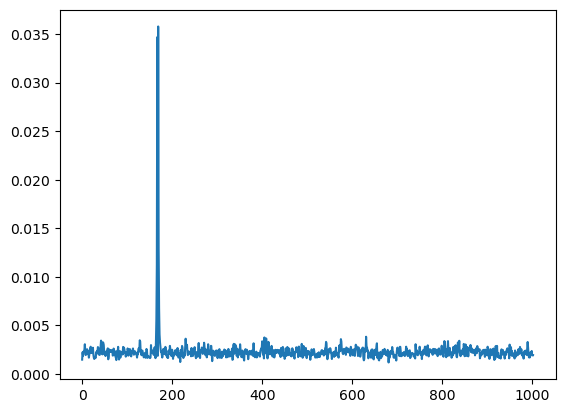

In [8]:
# parallel continuous version
import matplotlib.pyplot as plt

a = continuous_filter_csv_parallel(r"./fastHDMI/tests/sim/sim_continuous.csv")
b = Pearson_filter_csv_parallel(r"./fastHDMI/tests/sim/sim_continuous.csv")
plt.plot(a)
plt.show()

In [9]:
# # single-thread binary version
# import matplotlib.pyplot as plt

# a = binary_filter_csv(r"./fastHDMI/tests/sim/sim_binary.csv")
# plt.plot(a)
# plt.show()

Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size.
Reading variable names from csv file finished.


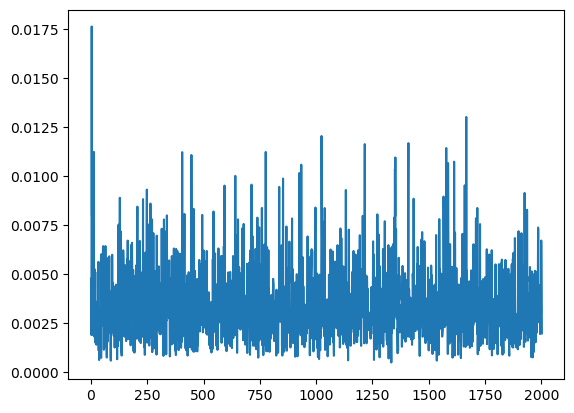

In [10]:
# parallel binary version
import matplotlib.pyplot as plt

a = binary_filter_csv_parallel(r"./fastHDMI/tests/sim/sim_binary.csv")
plt.plot(a)
plt.show()